In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve
import lightgbm as lgb

In [10]:
# ML
## Verify lightgbm can run
from sklearn.model_selection import train_test_split

In [11]:
all_data = pd.read_csv('./src/all_data.csv', index_col=0)

In [12]:
feature_engineered = pd.read_csv('./src/potential_features.csv', index_col=0)

In [13]:
all_data.head()

APP_NAME_CONTRACT_TYPE  APP_CODE_GENDER_F  APP_CODE_GENDER_M  \
SK_ID_CURR                                                                 
100002                           1                0.0                1.0   
100003                           1                1.0                0.0   
100004                           0                0.0                1.0   
100006                           1                1.0                0.0   
100007                           1                0.0                1.0   

            APP_CODE_GENDER_XNA  APP_FLAG_OWN_CAR  APP_FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
100002                      0.0                 1                    1   
100003                      0.0                 1                    0   
100004                      0.0                 0                    1   
100006                      0.0                 1                    1   
100007                      0.0                 1                    1   

            APP_NAME_TYPE_SUITE_Children  APP_NAME_TYPE_SUITE_Family  \
SK_ID_CURR                                                             
100002                               0.0                         0.0   
100003                               0.0                         1.0   
100004                               0.0                         0.0   
100006                               0.0                         0.0   
100007                               0.0                         0.0   

            APP_NAME_TYPE_SUITE_Groupofpeople  APP_NAME_TYPE_SUITE_Other_A  \
SK_ID_CURR                                                                   
100002                                    0.0                          0.0   
100003                                    0.0                          0.0   
100004                                    0.0                          0.0   
100006                                    0.0                          0.0   
100007                                    0.0                          0.0   

            ...  normalized_days_to_instalment  \
SK_ID_CURR  ...                                  
100002      ...                       0.001767   
100003      ...                       0.000111   
100004      ...                       0.001080   
100006      ...                       0.000308   
100007      ...                       0.000287   

            normalized_days_to_instalment_binary_01  \
SK_ID_CURR                                            
100002                                            0   
100003                                            0   
100004                                            0   
100006                                            0   
100007                                            0   

            normalized_days_to_instalment_binary_03  \
SK_ID_CURR                                            
100002                                            1   
100003                                            1   
100004                                            1   
100006                                            1   
100007                                            1   

            normalized_days_to_instalment_binary_06  \
SK_ID_CURR                                            
100002                                            1   
100003                                            1   
100004                                            1   
100006                                            1   
100007                                            1   

            payment_relative_income_binary_03  \
SK_ID_CURR                                      
100002                                      1   
100003                                      1   
100004                                      0   
100006                                      1   
100007                                      1   

            payment_relative_income_binary_07  avg_cred

## Train Test Split

In [14]:
train, test = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['TARGET'])

## LGBM for feature filtering

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 77895
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 705
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

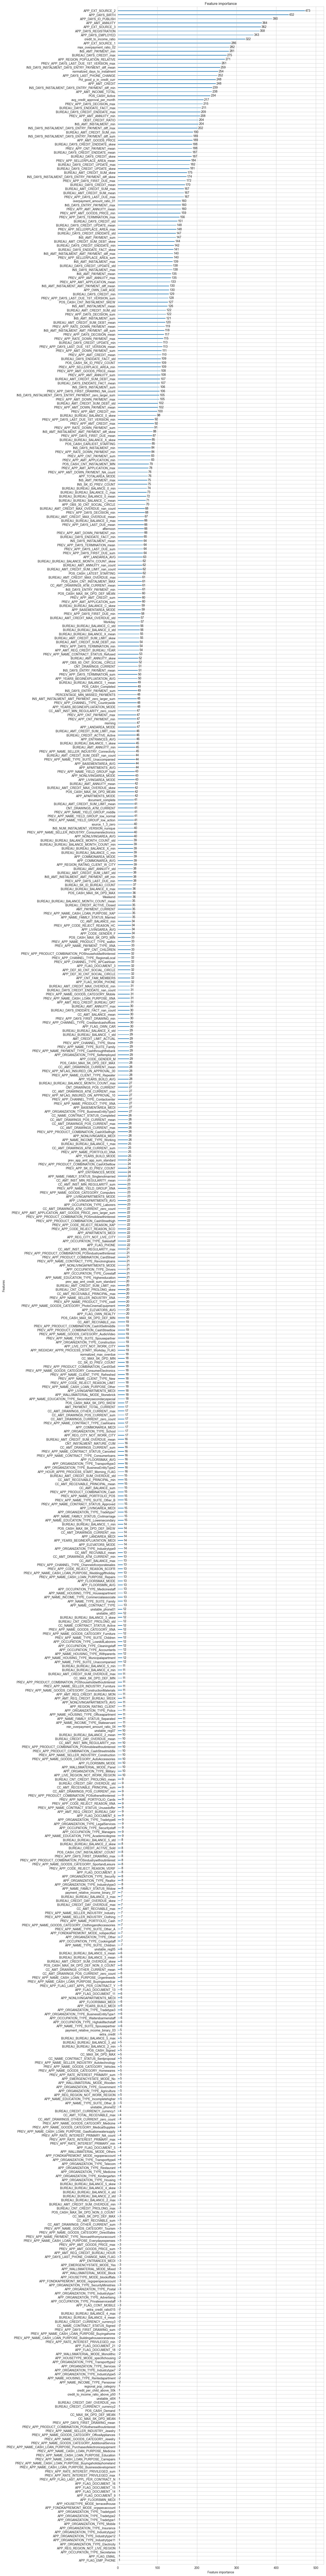

In [15]:
# load data using lightgbm
train_data = lgb.Dataset(train.drop('TARGET', axis=1), label=train['TARGET'])
# lightgbm parameters
params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc',
          'n_jobs': 1}  # njobs = 1 to avoid multithreading, keep reproducability
# lightgbm training
gbm = lgb.train(params, train_data, num_boost_round=1000)
# plot feature importance
lgb.plot_importance(gbm, figsize=(12, 150))

## Select important features

In [17]:
# select the top 100 features
feature_importance = pd.DataFrame()
feature_importance['Feature'] = all_data.drop('TARGET',axis=1).columns
feature_importance['Importance'] = gbm.feature_importance()

In [18]:
important_features = pd.DataFrame(gbm.feature_importance(), index=train.drop('TARGET',axis=1).columns, columns=['importance']).sort_values(
    by='importance', ascending=False)
# important_features['importance'] = important_features['importance'] / important_features['importance'].sum()
important_features_name = important_features[important_features['importance'] >3].index.tolist()

In [19]:
len(important_features_name)

537

In [20]:
important_features

importance
APP_EXT_SOURCE_2                            473
APP_DAYS_BIRTH                              432
APP_DAYS_ID_PUBLISH                         390
APP_AMT_ANNUITY                             364
APP_EXT_SOURCE_3                            362
...                                         ...
PREV_APP_RATE_INTEREST_PRIMARY_mean           0
APP_OCCUPATION_TYPE_Realtyagents              0
PREV_APP_RATE_DOWN_PAYMENT_NA_count           0
BUREAU_CREDIT_CURRENCY_currency4              0
APP_DAYS_EMPLOYED_NAN_FLAG                    0

[739 rows x 1 columns]

## Feature Engineering Passed Default LightGBM Features

In [21]:
important_features.loc[np.intersect1d(important_features_name, feature_engineered.columns)].sort_values(by='importance', ascending=False)

importance
max_overpayment_ratio_02                  282
normalized_days_to_instalment             254
Pct_good_p_in_credit_curr                 248
avg_credit_approval_per_month             217
DEBT_CREDIT_RATIO                         204
overpayment_amount_ratio_01               160
PERCENTAGE_MIN_MISSED_PAYMENTS             48
document_complete                          41
source_1_3_zero                            40
normalized_max_overdue                     18
unstable_id03                              12
unstable_phone01                           12
min_overpayment_amount_ratio_04            10
unstable_reg07                             10
payment_relative_income_binary_07           7
unstable_reg05                              6
payment_relative_income_binary_03           5
extra_credit                                5
unstable_phone02                            4

In [22]:
len(feature_engineered.columns)

29

In [23]:
# only use important feature to train and test

## Default LightGBM

### Train

In [24]:
train_data = lgb.Dataset(train[important_features_name], label=train['TARGET'])

In [25]:
gbm = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


In [26]:
def ROC_plot(model,model_name):
    pred = model.predict(test[important_features_name])
    fpr, tpr, thresholds = roc_curve(test['TARGET'], pred)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(test["TARGET"], pred):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'OOS ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

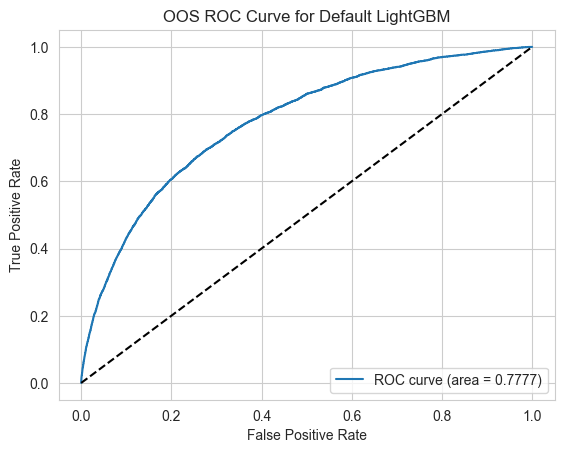

In [27]:
ROC_plot(gbm,'Default LightGBM')

### Onboarding Profit

In [28]:
# from profit on boarding
application_pnl = pd.read_csv('./src/application_character_with_pnl.csv', index_col=0)
application = pd.read_csv('./src/application_train.csv', index_col=0)

In [29]:
application_pnl.head()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                                      
100002         0.090032    0.090287         0.077441                 0.434783   
100003         0.132924    0.311736         0.271605                 0.478261   
100004         0.020025    0.022472         0.023569                 0.391304   
100006         0.109477    0.066837         0.063973                 0.739130   
100007         0.078975    0.116854         0.117845                 0.478261   

            NAME_TYPE_SUITE  WEEKDAY_APPR_PROCESS_START  Distance  TARGET  \
SK_ID_CURR                                                                  
100002             0.000000                    0.333333  1.025875       1   
100003             0.166667                    0.000000  1.361192       0   
100004             0.000000                    0.000000  0.457370       0   
100006             0.000000                    0.333333  1.312751       0   
100007             0.000000                    0.500000  1.291935       0   

           NAME_CONTRACT_TYPE  CLOSEST_PREVIOUS_LOAN_PROFIT  
SK_ID_CURR                                                   
100002             Cash loans                -350635.125590  
100003             Cash loans                 497317.952788  
100004        Revolving loans                    200.763725  
100006             Cash loans                  49068.551471  
100007             Cash loans                 123169.954206

In [30]:
def onboarding_profit_margin(pred,thresholds):
    profit =application_pnl.loc[test.index]['CLOSEST_PREVIOUS_LOAN_PROFIT'].values
    loan_amount = application.loc[test.index]['AMT_CREDIT'].values
    return [((pred>th).astype(int)*profit).sum()/((pred>th).astype(int)*loan_amount).sum() for th in thresholds]
def onboarding_loan_amount(pred,thresholds):
    loan_amount = application.loc[test.index]['AMT_CREDIT'].values
    return [((pred>th).astype(int)*loan_amount).sum() for th in thresholds]

In [31]:
def Onboarding_plot(model,model_name):
    pred = model.predict(test[important_features_name])
    _, _, thresholds = roc_curve(test['TARGET'], pred)
    profit_margin = onboarding_profit_margin(pred, thresholds)
    loan_amount = onboarding_loan_amount(pred, thresholds)
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Thresholds')
    ax1.set_ylabel('Profit Margin', color=color)
    ax1.plot(thresholds, profit_margin, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Loan Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(thresholds, loan_amount, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Onboarding Profit Margin and Loan Amount for {model_name}')
    plt.xlim(0,1)
    plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_10608\1574911502.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return [((pred>th).astype(int)*profit).sum()/((pred>th).astype(int)*loan_amount).sum() for th in thresholds]


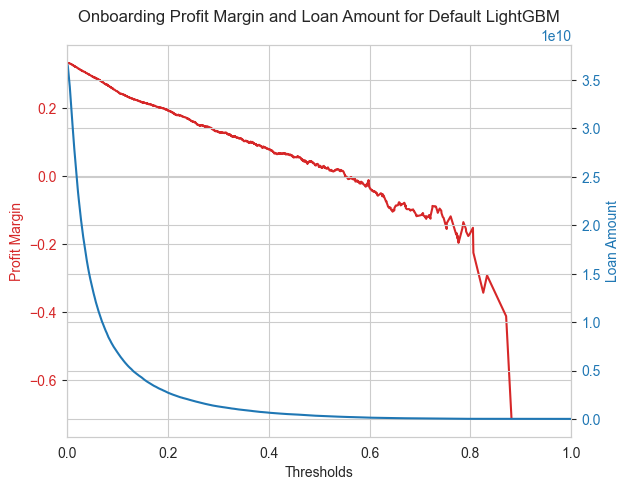

In [32]:
Onboarding_plot(gbm,'Default LightGBM')

## Lightgbm Tuning

In [38]:
from optuna.integration.lightgbm import LightGBMTunerCV as tunerCV

params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc'}
train_data = lgb.Dataset(train[important_features_name], label=train['TARGET'])
gbm_tuned_cv = tunerCV(params, train_data, num_boost_round=1000, verbose_eval=100, early_stopping_rounds=10,nfold=5)

[I 2024-01-03 23:42:58,650] A new study created in memory with name: no-name-2f573c7e-fbb1-44da-b2f1-e0a2645afac2


In [39]:
gbm_tuned_cv.run()


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction, val_score: 0.781297:  14%|#4        | 1/7 [00:44<04:28, 44.79s/it][I 2024-01-03 23:43:44,742] Trial 0 finished with value: 0.7812972130614173 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  14%|#4        | 1/7 [00:44<04:28, 44.79s/it]

Early stopping, best iteration is:
[133]	cv_agg's valid auc: 0.781297 + 0.00247068
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297:  29%|##8       | 2/7 [01:28<03:40, 44.02s/it][I 2024-01-03 23:44:28,218] Trial 1 finished with value: 0.780286745844047 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  29%|##8       | 2/7 [01:28<03:40, 44.02s/it]

Early stopping, best iteration is:
[127]	cv_agg's valid auc: 0.780287 + 0.00308062
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297:  43%|####2     | 3/7 [02:08<02:49, 42.49s/it][I 2024-01-03 23:45:08,902] Trial 2 finished with value: 0.7806606399771078 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  43%|####2     | 3/7 [02:08<02:49, 42.49s/it]

Early stopping, best iteration is:
[145]	cv_agg's valid auc: 0.780661 + 0.00311471
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297:  57%|#####7    | 4/7 [02:48<02:04, 41.40s/it][I 2024-01-03 23:45:48,629] Trial 3 finished with value: 0.7807148141607787 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  57%|#####7    | 4/7 [02:48<02:04, 41.40s/it]

Early stopping, best iteration is:
[115]	cv_agg's valid auc: 0.780715 + 0.00255172
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297:  71%|#######1  | 5/7 [03:30<01:23, 41.58s/it][I 2024-01-03 23:46:30,534] Trial 4 finished with value: 0.7802273938621817 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  71%|#######1  | 5/7 [03:30<01:23, 41.58s/it]

Early stopping, best iteration is:
[134]	cv_agg's valid auc: 0.780227 + 0.00267029
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297:  86%|########5 | 6/7 [04:12<00:41, 41.70s/it][I 2024-01-03 23:47:12,473] Trial 5 finished with value: 0.7804256845599229 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.7812972130614173.

feature_fraction, val_score: 0.781297:  86%|########5 | 6/7 [04:12<00:41, 41.70s/it]

Early stopping, best iteration is:
[137]	cv_agg's valid auc: 0.780426 + 0.00286808
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


feature_fraction, val_score: 0.781297: 100%|##########| 7/7 [04:46<00:00, 41.00s/it]


Early stopping, best iteration is:
[119]	cv_agg's valid auc: 0.779884 + 0.00338908



num_leaves, val_score: 0.781297:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.781297:   5%|5         | 1/20 [01:12<23:00, 72.68s/it][I 2024-01-03 23:48:59,615] Trial 7 finished with value: 0.7726202599777302 and parameters: {'num_leaves': 198}. Best is trial 7 with value: 0.7726202599777302.

num_leaves, val_score: 0.781297:   5%|5         | 1/20 [01:12<23:00, 72.68s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.782340:  10%|#         | 2/20 [02:03<18:00, 60.05s/it][I 2024-01-03 23:49:50,847] Trial 8 finished with value: 0.7823401599511663 and parameters: {'num_leaves': 11}. Best is trial 8 with value: 0.7823401599511663.

num_leaves, val_score: 0.782340:  10%|#         | 2/20 [02:03<18:00, 60.05s/it]

Early stopping, best iteration is:
[213]	cv_agg's valid auc: 0.78234 + 0.00242396
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Li


num_leaves, val_score: 0.782340:  15%|#5        | 3/20 [03:49<22:52, 80.72s/it][I 2024-01-03 23:51:36,168] Trial 9 finished with value: 0.7714996980331671 and parameters: {'num_leaves': 239}. Best is trial 8 with value: 0.7823401599511663.

num_leaves, val_score: 0.782340:  15%|#5        | 3/20 [03:49<22:52, 80.72s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.782857:  20%|##        | 4/20 [05:11<21:42, 81.43s/it][I 2024-01-03 23:52:58,681] Trial 10 finished with value: 0.7828570651085961 and parameters: {'num_leaves': 8}. Best is trial 10 with value: 0.7828570651085961.

num_leaves, val_score: 0.782857:  20%|##        | 4/20 [05:11<21:42, 81.43s/it]

Early stopping, best iteration is:
[352]	cv_agg's valid auc: 0.782857 + 0.00236366
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L


num_leaves, val_score: 0.783598:  25%|##5       | 5/20 [07:18<24:27, 97.84s/it][I 2024-01-03 23:55:05,599] Trial 11 finished with value: 0.7835982376805337 and parameters: {'num_leaves': 4}. Best is trial 11 with value: 0.7835982376805337.


Early stopping, best iteration is:
[778]	cv_agg's valid auc: 0.783598 + 0.00307215



num_leaves, val_score: 0.783598:  25%|##5       | 5/20 [07:18<24:27, 97.84s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  30%|###       | 6/20 [09:19<24:36, 105.49s/it][I 2024-01-03 23:57:05,961] Trial 12 finished with value: 0.7762701505495893 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.7835982376805337.


[1000]	cv_agg's valid auc: 0.77627 + 0.00284532
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid auc: 0.77627 + 0.00284532



num_leaves, val_score: 0.783598:  30%|###       | 6/20 [09:19<24:36, 105.49s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  35%|###5      | 7/20 [10:24<20:01, 92.41s/it] 

Early stopping, best iteration is:
[106]	cv_agg's valid auc: 0.778516 + 0.00242734


[I 2024-01-03 23:58:11,433] Trial 13 finished with value: 0.7785161200684153 and parameters: {'num_leaves': 72}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  35%|###5      | 7/20 [10:24<20:01, 92.41s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  40%|####      | 8/20 [11:32<16:54, 84.52s/it]

Early stopping, best iteration is:
[101]	cv_agg's valid auc: 0.777245 + 0.00300996


[I 2024-01-03 23:59:19,076] Trial 14 finished with value: 0.7772445204724296 and parameters: {'num_leaves': 89}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  40%|####      | 8/20 [11:32<16:54, 84.52s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  45%|####5     | 9/20 [12:29<13:54, 75.90s/it][I 2024-01-04 00:00:16,022] Trial 15 finished with value: 0.7797868093068728 and parameters: {'num_leaves': 53}. Best is trial 11 with value: 0.7835982376805337.


Early stopping, best iteration is:
[98]	cv_agg's valid auc: 0.779787 + 0.00187606



num_leaves, val_score: 0.783598:  45%|####5     | 9/20 [12:29<13:54, 75.90s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

Early stopping, best iteration is:
[93]	cv_agg's valid auc: 0.774696 + 0.00347111


num_leaves, val_score: 0.783598:  50%|#####     | 10/20 [13:47<12:47, 76.79s/it][I 2024-01-04 00:01:34,814] Trial 16 finished with value: 0.774696044819513 and parameters: {'num_leaves': 140}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  50%|#####     | 10/20 [13:47<12:47, 76.79s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  55%|#####5    | 11/20 [14:45<10:37, 70.88s/it][I 2024-01-04 00:02:32,269] Trial 17 finished with value: 0.7810059088190766 and parameters: {'num_leaves': 36}. Best is trial 11 with value: 0.7835982376805337.


Early stopping, best iteration is:
[131]	cv_agg's valid auc: 0.781006 + 0.00249387



num_leaves, val_score: 0.783598:  55%|#####5    | 11/20 [14:45<10:37, 70.88s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

Early stopping, best iteration is:
[98]	cv_agg's valid auc: 0.775835 + 0.00284378


num_leaves, val_score: 0.783598:  60%|######    | 12/20 [16:02<09:41, 72.74s/it][I 2024-01-04 00:03:49,283] Trial 18 finished with value: 0.7758352728465259 and parameters: {'num_leaves': 122}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  60%|######    | 12/20 [16:02<09:41, 72.74s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  65%|######5   | 13/20 [17:13<08:25, 72.25s/it][I 2024-01-04 00:05:00,424] Trial 19 finished with value: 0.7765151216168082 and parameters: {'num_leaves': 113}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  65%|######5   | 13/20 [17:13<08:25, 72.25s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  70%|#######   | 14/20 [18:06<06:39, 66.53s/it]

Early stopping, best iteration is:
[119]	cv_agg's valid auc: 0.780471 + 0.00286094


[I 2024-01-04 00:05:53,725] Trial 20 finished with value: 0.7804708242020079 and parameters: {'num_leaves': 33}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  70%|#######   | 14/20 [18:06<06:39, 66.53s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  75%|#######5  | 15/20 [19:18<05:41, 68.25s/it][I 2024-01-04 00:07:05,924] Trial 21 finished with value: 0.7827706984773315 and parameters: {'num_leaves': 9}. Best is trial 11 with value: 0.7835982376805337.


Early stopping, best iteration is:
[320]	cv_agg's valid auc: 0.782771 + 0.00232564



num_leaves, val_score: 0.783598:  75%|#######5  | 15/20 [19:19<05:41, 68.25s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  80%|########  | 16/20 [21:22<05:39, 84.83s/it][I 2024-01-04 00:09:09,266] Trial 22 finished with value: 0.7835982376805337 and parameters: {'num_leaves': 4}. Best is trial 11 with value: 0.7835982376805337.


Early stopping, best iteration is:
[778]	cv_agg's valid auc: 0.783598 + 0.00307215



num_leaves, val_score: 0.783598:  80%|########  | 16/20 [21:22<05:39, 84.83s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  85%|########5 | 17/20 [22:19<03:49, 76.41s/it]

Early stopping, best iteration is:
[109]	cv_agg's valid auc: 0.779136 + 0.00282466


[I 2024-01-04 00:10:06,082] Trial 23 finished with value: 0.7791362420878043 and parameters: {'num_leaves': 49}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  85%|########5 | 17/20 [22:19<03:49, 76.41s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  90%|######### | 18/20 [24:41<03:12, 96.23s/it]

[1000]	cv_agg's valid auc: 0.78291 + 0.00298837
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid auc: 0.78291 + 0.00298837


[I 2024-01-04 00:12:28,459] Trial 24 finished with value: 0.782909667348135 and parameters: {'num_leaves': 3}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  90%|######### | 18/20 [24:41<03:12, 96.23s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598:  95%|#########5| 19/20 [26:08<01:33, 93.54s/it][I 2024-01-04 00:13:55,731] Trial 25 finished with value: 0.7733567589296477 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.7835982376805337.

num_leaves, val_score: 0.783598:  95%|#########5| 19/20 [26:08<01:33, 93.54s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


num_leaves, val_score: 0.783598: 100%|##########| 20/20 [27:13<00:00, 81.66s/it]

bagging, val_score: 0.783598:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783598:  10%|#         | 1/10 [01:40<15:05, 100.63s/it]

Early stopping, best iteration is:
[541]	cv_agg's valid auc: 0.782112 + 0.00292663


[I 2024-01-04 00:16:40,726] Trial 27 finished with value: 0.7821117197951468 and parameters: {'bagging_fraction': 0.9392922137238351, 'bagging_freq': 5}. Best is trial 27 with value: 0.7821117197951468.

bagging, val_score: 0.783598:  10%|#         | 1/10 [01:40<15:05, 100.63s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783598:  20%|##        | 2/10 [02:35<09:50, 73.85s/it] [I 2024-01-04 00:17:35,815] Trial 28 finished with value: 0.7808238687924579 and parameters: {'bagging_fraction': 0.41249770641804434, 'bagging_freq': 1}. Best is trial 27 with value: 0.7821117197951468.


Early stopping, best iteration is:
[446]	cv_agg's valid auc: 0.780824 + 0.0027787



bagging, val_score: 0.783598:  20%|##        | 2/10 [02:35<09:50, 73.85s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783598:  30%|###       | 3/10 [04:38<11:12, 96.12s/it][I 2024-01-04 00:19:38,438] Trial 29 finished with value: 0.7829732464572647 and parameters: {'bagging_fraction': 0.9815711354238293, 'bagging_freq': 7}. Best is trial 29 with value: 0.7829732464572647.


Early stopping, best iteration is:
[652]	cv_agg's valid auc: 0.782973 + 0.0028359



bagging, val_score: 0.783598:  30%|###       | 3/10 [04:38<11:12, 96.12s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783598:  40%|####      | 4/10 [06:33<10:22, 103.71s/it]

Early stopping, best iteration is:
[636]	cv_agg's valid auc: 0.782803 + 0.00317148


[I 2024-01-04 00:21:33,795] Trial 30 finished with value: 0.7828033919038333 and parameters: {'bagging_fraction': 0.9415252074568112, 'bagging_freq': 7}. Best is trial 29 with value: 0.7829732464572647.

bagging, val_score: 0.783598:  40%|####      | 4/10 [06:33<10:22, 103.71s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679:  50%|#####     | 5/10 [08:31<09:04, 108.95s/it][I 2024-01-04 00:23:32,032] Trial 31 finished with value: 0.7836794424684852 and parameters: {'bagging_fraction': 0.7472212635922346, 'bagging_freq': 7}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[679]	cv_agg's valid auc: 0.783679 + 0.00260285



bagging, val_score: 0.783679:  50%|#####     | 5/10 [08:31<09:04, 108.95s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679:  60%|######    | 6/10 [09:34<06:12, 93.03s/it] [I 2024-01-04 00:24:34,158] Trial 32 finished with value: 0.7805202856499595 and parameters: {'bagging_fraction': 0.7119425121447137, 'bagging_freq': 7}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[399]	cv_agg's valid auc: 0.78052 + 0.00297962



bagging, val_score: 0.783679:  60%|######    | 6/10 [09:34<06:12, 93.03s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679:  70%|#######   | 7/10 [10:56<04:28, 89.53s/it][I 2024-01-04 00:25:56,532] Trial 33 finished with value: 0.782356719373639 and parameters: {'bagging_fraction': 0.7781302803296901, 'bagging_freq': 5}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[498]	cv_agg's valid auc: 0.782357 + 0.00286399



bagging, val_score: 0.783679:  70%|#######   | 7/10 [10:56<04:28, 89.53s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679:  80%|########  | 8/10 [13:02<03:22, 101.31s/it][I 2024-01-04 00:28:03,006] Trial 34 finished with value: 0.783436980403048 and parameters: {'bagging_fraction': 0.9529443615296314, 'bagging_freq': 7}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[695]	cv_agg's valid auc: 0.783437 + 0.00250475



bagging, val_score: 0.783679:  80%|########  | 8/10 [13:02<03:22, 101.31s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679:  90%|######### | 9/10 [14:30<01:37, 97.17s/it] [I 2024-01-04 00:29:31,067] Trial 35 finished with value: 0.7818804637623973 and parameters: {'bagging_fraction': 0.8069654086083158, 'bagging_freq': 3}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[518]	cv_agg's valid auc: 0.78188 + 0.00292054



bagging, val_score: 0.783679:  90%|######### | 9/10 [14:31<01:37, 97.17s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


bagging, val_score: 0.783679: 100%|##########| 10/10 [15:47<00:00, 90.80s/it][I 2024-01-04 00:30:47,627] Trial 36 finished with value: 0.7815699544118753 and parameters: {'bagging_fraction': 0.6003621365681155, 'bagging_freq': 5}. Best is trial 31 with value: 0.7836794424684852.


Early stopping, best iteration is:
[544]	cv_agg's valid auc: 0.78157 + 0.0027839


bagging, val_score: 0.783679: 100%|##########| 10/10 [15:47<00:00, 94.76s/it]

feature_fraction_stage2, val_score: 0.783679:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679:  17%|#6        | 1/6 [01:57<09:49, 117.80s/it]

Early stopping, best iteration is:
[740]	cv_agg's valid auc: 0.7835 + 0.00267394


[I 2024-01-04 00:32:45,478] Trial 37 finished with value: 0.7834999489167015 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 0.7834999489167015.

feature_fraction_stage2, val_score: 0.783679:  17%|#6        | 1/6 [01:57<09:49, 117.80s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679:  33%|###3      | 2/6 [03:44<07:25, 111.37s/it]

Early stopping, best iteration is:
[687]	cv_agg's valid auc: 0.783112 + 0.00265131


[I 2024-01-04 00:34:32,345] Trial 38 finished with value: 0.7831120942786755 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.7834999489167015.

feature_fraction_stage2, val_score: 0.783679:  33%|###3      | 2/6 [03:44<07:25, 111.37s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679:  50%|#####     | 3/6 [05:13<05:03, 101.11s/it][I 2024-01-04 00:36:01,249] Trial 39 finished with value: 0.7821326669992962 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 0.7834999489167015.


Early stopping, best iteration is:
[523]	cv_agg's valid auc: 0.782133 + 0.00320793



feature_fraction_stage2, val_score: 0.783679:  50%|#####     | 3/6 [05:13<05:03, 101.11s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679:  67%|######6   | 4/6 [07:07<03:32, 106.04s/it]

Early stopping, best iteration is:
[648]	cv_agg's valid auc: 0.783424 + 0.00312321


[I 2024-01-04 00:37:54,841] Trial 40 finished with value: 0.7834241930263 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 0.7834999489167015.

feature_fraction_stage2, val_score: 0.783679:  67%|######6   | 4/6 [07:07<03:32, 106.04s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679:  83%|########3 | 5/6 [08:37<01:40, 100.55s/it][I 2024-01-04 00:39:25,667] Trial 41 finished with value: 0.7825746320673094 and parameters: {'feature_fraction': 0.716}. Best is trial 37 with value: 0.7834999489167015.


Early stopping, best iteration is:
[562]	cv_agg's valid auc: 0.782575 + 0.00305789



feature_fraction_stage2, val_score: 0.783679:  83%|########3 | 5/6 [08:38<01:40, 100.55s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


feature_fraction_stage2, val_score: 0.783679: 100%|##########| 6/6 [10:18<00:00, 100.53s/it][I 2024-01-04 00:41:06,170] Trial 42 finished with value: 0.7834124686864514 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 0.7834999489167015.


Early stopping, best iteration is:
[650]	cv_agg's valid auc: 0.783412 + 0.00303207


feature_fraction_stage2, val_score: 0.783679: 100%|##########| 6/6 [10:18<00:00, 103.09s/it]

regularization_factors, val_score: 0.783679:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.783679:   5%|5         | 1/20 [01:55<36:30, 115.29s/it]

Early stopping, best iteration is:
[743]	cv_agg's valid auc: 0.783657 + 0.00328167


[I 2024-01-04 00:43:01,520] Trial 43 finished with value: 0.7836566738022287 and parameters: {'lambda_l1': 6.080663609476509e-07, 'lambda_l2': 0.16447482194709936}. Best is trial 43 with value: 0.7836566738022287.

regularization_factors, val_score: 0.783679:   5%|5         | 1/20 [01:55<36:30, 115.29s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.783679:  10%|#         | 2/20 [03:32<31:26, 104.83s/it][I 2024-01-04 00:44:39,020] Trial 44 finished with value: 0.7823670432527693 and parameters: {'lambda_l1': 1.2508272791009584e-06, 'lambda_l2': 0.14167166727986347}. Best is trial 43 with value: 0.7836566738022287.


Early stopping, best iteration is:
[561]	cv_agg's valid auc: 0.782367 + 0.00293986



regularization_factors, val_score: 0.783679:  10%|#         | 2/20 [03:32<31:26, 104.83s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.784729:  15%|#5        | 3/20 [05:16<29:35, 104.45s/it]

Early stopping, best iteration is:
[651]	cv_agg's valid auc: 0.784729 + 0.00264427


[I 2024-01-04 00:46:23,015] Trial 45 finished with value: 0.7847290101867654 and parameters: {'lambda_l1': 1.0780063443745916e-07, 'lambda_l2': 6.405884396650644}. Best is trial 45 with value: 0.7847290101867654.

regularization_factors, val_score: 0.784729:  15%|#5        | 3/20 [05:16<29:35, 104.45s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  20%|##        | 4/20 [07:21<29:57, 112.32s/it][I 2024-01-04 00:48:27,404] Trial 46 finished with value: 0.7855905657610647 and parameters: {'lambda_l1': 3.5741103623189667e-08, 'lambda_l2': 7.947243769714823}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[784]	cv_agg's valid auc: 0.785591 + 0.00327236



regularization_factors, val_score: 0.785591:  20%|##        | 4/20 [07:21<29:57, 112.32s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  25%|##5       | 5/20 [09:00<26:52, 107.47s/it][I 2024-01-04 00:50:06,273] Trial 47 finished with value: 0.7845834450276498 and parameters: {'lambda_l1': 3.535085429401106e-08, 'lambda_l2': 7.0312323279517885}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[612]	cv_agg's valid auc: 0.784583 + 0.00311302



regularization_factors, val_score: 0.785591:  25%|##5       | 5/20 [09:00<26:52, 107.47s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  30%|###       | 6/20 [10:43<24:45, 106.09s/it][I 2024-01-04 00:51:49,676] Trial 48 finished with value: 0.7847142422843806 and parameters: {'lambda_l1': 3.526966396375301e-08, 'lambda_l2': 8.24610266544561}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[649]	cv_agg's valid auc: 0.784714 + 0.00297337



regularization_factors, val_score: 0.785591:  30%|###       | 6/20 [10:43<24:45, 106.09s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  35%|###5      | 7/20 [12:32<23:10, 106.99s/it][I 2024-01-04 00:53:38,531] Trial 49 finished with value: 0.7850485525465711 and parameters: {'lambda_l1': 1.4196520111761101e-08, 'lambda_l2': 6.950090029070769}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[678]	cv_agg's valid auc: 0.785049 + 0.0028849



regularization_factors, val_score: 0.785591:  35%|###5      | 7/20 [12:32<23:10, 106.99s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  40%|####      | 8/20 [14:21<21:30, 107.55s/it][I 2024-01-04 00:55:27,263] Trial 50 finished with value: 0.7846991034956832 and parameters: {'lambda_l1': 1.55778553583366e-08, 'lambda_l2': 8.399554049139036}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[682]	cv_agg's valid auc: 0.784699 + 0.00334085



regularization_factors, val_score: 0.785591:  40%|####      | 8/20 [14:21<21:30, 107.55s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  45%|####5     | 9/20 [16:23<20:33, 112.13s/it]

Early stopping, best iteration is:
[784]	cv_agg's valid auc: 0.785344 + 0.00338022


[I 2024-01-04 00:57:29,489] Trial 51 finished with value: 0.7853440592542175 and parameters: {'lambda_l1': 1.1730154629119894e-08, 'lambda_l2': 7.598865446306967}. Best is trial 46 with value: 0.7855905657610647.

regularization_factors, val_score: 0.785591:  45%|####5     | 9/20 [16:23<20:33, 112.13s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  50%|#####     | 10/20 [18:10<18:27, 110.73s/it]

Early stopping, best iteration is:
[678]	cv_agg's valid auc: 0.785049 + 0.00288493


[I 2024-01-04 00:59:17,070] Trial 52 finished with value: 0.7850485146955742 and parameters: {'lambda_l1': 1.4884716539082644e-08, 'lambda_l2': 6.950977159536016}. Best is trial 46 with value: 0.7855905657610647.

regularization_factors, val_score: 0.785591:  50%|#####     | 10/20 [18:10<18:27, 110.73s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  55%|#####5    | 11/20 [20:05<16:48, 112.02s/it][I 2024-01-04 01:01:12,017] Trial 53 finished with value: 0.7847639810926538 and parameters: {'lambda_l1': 1.112496867526627e-08, 'lambda_l2': 9.983195025319935}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[729]	cv_agg's valid auc: 0.784764 + 0.00316221



regularization_factors, val_score: 0.785591:  55%|#####5    | 11/20 [20:05<16:48, 112.02s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  60%|######    | 12/20 [22:10<15:27, 115.92s/it]

Early stopping, best iteration is:
[795]	cv_agg's valid auc: 0.785414 + 0.0030075


[I 2024-01-04 01:03:16,866] Trial 54 finished with value: 0.7854137688687648 and parameters: {'lambda_l1': 1.6937399436295937e-08, 'lambda_l2': 9.85440963357172}. Best is trial 46 with value: 0.7855905657610647.

regularization_factors, val_score: 0.785591:  60%|######    | 12/20 [22:10<15:27, 115.92s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  65%|######5   | 13/20 [23:51<12:58, 111.22s/it][I 2024-01-04 01:04:57,269] Trial 55 finished with value: 0.7843191681601718 and parameters: {'lambda_l1': 1.0111865871444081e-08, 'lambda_l2': 8.270158221297518}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[612]	cv_agg's valid auc: 0.784319 + 0.0029877



regularization_factors, val_score: 0.785591:  65%|######5   | 13/20 [23:51<12:58, 111.22s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  70%|#######   | 14/20 [25:36<10:56, 109.47s/it][I 2024-01-04 01:06:42,678] Trial 56 finished with value: 0.7836794424684852 and parameters: {'lambda_l1': 1.0607012749004277e-08, 'lambda_l2': 4.3893729920073404e-08}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[679]	cv_agg's valid auc: 0.783679 + 0.00260285



regularization_factors, val_score: 0.785591:  70%|#######   | 14/20 [25:36<10:56, 109.47s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  75%|#######5  | 15/20 [27:24<09:05, 109.12s/it][I 2024-01-04 01:08:31,007] Trial 57 finished with value: 0.7847584663011347 and parameters: {'lambda_l1': 0.010848365092730603, 'lambda_l2': 7.784826007433574}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[685]	cv_agg's valid auc: 0.784758 + 0.0031337



regularization_factors, val_score: 0.785591:  75%|#######5  | 15/20 [27:24<09:05, 109.12s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  80%|########  | 16/20 [29:01<07:01, 105.31s/it]

Early stopping, best iteration is:
[605]	cv_agg's valid auc: 0.783211 + 0.00288012


[I 2024-01-04 01:10:07,455] Trial 58 finished with value: 0.7832107243149268 and parameters: {'lambda_l1': 1.033657403104084e-08, 'lambda_l2': 0.3393405380423462}. Best is trial 46 with value: 0.7855905657610647.

regularization_factors, val_score: 0.785591:  80%|########  | 16/20 [29:01<07:01, 105.31s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  85%|########5 | 17/20 [30:43<05:12, 104.24s/it][I 2024-01-04 01:11:49,224] Trial 59 finished with value: 0.7835133092856414 and parameters: {'lambda_l1': 1.0216024267860406e-06, 'lambda_l2': 0.5103579233601552}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[648]	cv_agg's valid auc: 0.783513 + 0.00278666



regularization_factors, val_score: 0.785591:  85%|########5 | 17/20 [30:43<05:12, 104.24s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  90%|######### | 18/20 [32:20<03:24, 102.35s/it][I 2024-01-04 01:13:27,171] Trial 60 finished with value: 0.7831659694662731 and parameters: {'lambda_l1': 1.0523392598869941e-07, 'lambda_l2': 0.758777815700076}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[613]	cv_agg's valid auc: 0.783166 + 0.00303752



regularization_factors, val_score: 0.785591:  90%|######### | 18/20 [32:20<03:24, 102.35s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591:  95%|#########5| 19/20 [34:10<01:44, 104.50s/it]

Early stopping, best iteration is:
[687]	cv_agg's valid auc: 0.784691 + 0.00300603


[I 2024-01-04 01:15:16,684] Trial 61 finished with value: 0.7846910202602091 and parameters: {'lambda_l1': 0.09797358432025954, 'lambda_l2': 7.666439665682401}. Best is trial 46 with value: 0.7855905657610647.

regularization_factors, val_score: 0.785591:  95%|#########5| 19/20 [34:10<01:44, 104.50s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


regularization_factors, val_score: 0.785591: 100%|##########| 20/20 [35:58<00:00, 105.64s/it][I 2024-01-04 01:17:04,987] Trial 62 finished with value: 0.7847226217163636 and parameters: {'lambda_l1': 0.020718646871747622, 'lambda_l2': 9.45379095669114}. Best is trial 46 with value: 0.7855905657610647.


Early stopping, best iteration is:
[684]	cv_agg's valid auc: 0.784723 + 0.00288529


regularization_factors, val_score: 0.785591: 100%|##########| 20/20 [35:58<00:00, 107.94s/it]

min_data_in_leaf, val_score: 0.785591:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


min_data_in_leaf, val_score: 0.785591:  20%|##        | 1/5 [02:03<08:13, 123.36s/it]

Early stopping, best iteration is:
[784]	cv_agg's valid auc: 0.785591 + 0.00327236


[I 2024-01-04 01:19:08,402] Trial 63 finished with value: 0.7855905657610647 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.7855905657610647.

min_data_in_leaf, val_score: 0.785591:  20%|##        | 1/5 [02:03<08:13, 123.36s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


min_data_in_leaf, val_score: 0.785591:  40%|####      | 2/5 [04:06<06:09, 123.05s/it]

Early stopping, best iteration is:
[784]	cv_agg's valid auc: 0.785591 + 0.00327236


[I 2024-01-04 01:21:11,232] Trial 64 finished with value: 0.7855905657610647 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.7855905657610647.

min_data_in_leaf, val_score: 0.785591:  40%|####      | 2/5 [04:06<06:09, 123.05s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


min_data_in_leaf, val_score: 0.785591:  60%|######    | 3/5 [05:54<03:52, 116.47s/it][I 2024-01-04 01:22:59,867] Trial 65 finished with value: 0.7848475289468558 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.7855905657610647.


Early stopping, best iteration is:
[685]	cv_agg's valid auc: 0.784848 + 0.00310581



min_data_in_leaf, val_score: 0.785591:  60%|######    | 3/5 [05:54<03:52, 116.47s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


min_data_in_leaf, val_score: 0.785591:  80%|########  | 4/5 [07:56<01:58, 118.67s/it]

Early stopping, best iteration is:
[784]	cv_agg's valid auc: 0.785591 + 0.00327236


[I 2024-01-04 01:25:01,920] Trial 66 finished with value: 0.7855905657610647 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.7855905657610647.

min_data_in_leaf, val_score: 0.785591:  80%|########  | 4/5 [07:56<01:58, 118.67s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat


min_data_in_leaf, val_score: 0.785591: 100%|##########| 5/5 [09:44<00:00, 114.85s/it][I 2024-01-04 01:26:49,985] Trial 67 finished with value: 0.7850726590868228 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.7855905657610647.


Early stopping, best iteration is:
[682]	cv_agg's valid auc: 0.785073 + 0.00302846


min_data_in_leaf, val_score: 0.785591: 100%|##########| 5/5 [09:44<00:00, 117.00s/it]


In [40]:
with open('./src/lightgbm_tuned_cv.txt', 'w') as f:
    f.write(str(gbm_tuned_cv.best_params))

In [41]:
import pickle
with open('./src/lightgbm_tuned_cv.pkl', 'wb') as f:
    pickle.dump(gbm_tuned_cv, f)

In [43]:
gbm_tuned_cv.best_params

{'force_col_wise': True,
 'random_state': 42,
 'objective': 'binary',
 'metric': 'auc',
 'feature_pre_filter': False,
 'lambda_l1': 3.5741103623189667e-08,
 'lambda_l2': 7.947243769714823,
 'num_leaves': 4,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.7472212635922346,
 'bagging_freq': 7,
 'min_child_samples': 20}

In [34]:

# train_opt,valid_opt =  train_test_split(train.loc[:,important_features_name+['TARGET']], test_size=0.2, random_state=42, stratify=train['TARGET'])
# train_opt_data = lgb.Dataset(train_opt.drop('TARGET', axis=1), label=train_opt['TARGET'])
# valid_opt_data = lgb.Dataset(valid_opt.drop('TARGET', axis=1), label=valid_opt['TARGET'])
# 
# params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc'}
# # set_verbosity(0) will mute LightGBM's output
# 
# gbm_tuned = lgb.train(params, train_opt_data, valid_sets=[train_opt_data, valid_opt_data], early_stopping_rounds=10, verbose_eval=100)


K fold validation as required

In [35]:
# save model
gbm_tuned.save_model('./src/lightgbm_tuned.txt')

NameError: name 'gbm_tuned' is not defined

In [ ]:
ROC_plot(gbm_tuned,'Tuned LightGBM')

In [ ]:
Onboarding_plot(gbm_tuned,'Tuned LightGBM')